In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import shutil
from PIL import Image

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.19.5
TensorFlow Version :2.4.1
Matplotlib Version :3.2.2


In [ ]:
colab=True
try:
  from google.colab import drive
except:
  colab =False
if colab : 
    drive.mount('/content/drive')
    print('g-drive mounted.')
else : print('local drive.')

Mounted at /content/drive
g-drive mounted.


In [ ]:
x_path = "/content/drive/MyDrive/SCSA_Project/files/final_input.npy"
y_path = "/content/drive/MyDrive/SCSA_Project/files/final_labels.npy"

imgs = np.load(x_path)
labels = np.load(y_path)

x_train = imgs
y_train = labels

print(imgs.shape)
print(labels.shape)

(2800, 120, 160, 3)
(2800, 1)


In [ ]:
x_path = "/content/drive/MyDrive/SCSA_Project/files/test_image.npy"
y_path = "/content/drive/MyDrive/SCSA_Project/files/test_label.npy"

x_test = np.load(x_path)
y_test = np.load(y_path)

print(x_test.shape)
print(y_test.shape)

(588, 120, 160, 3)
(588, 1)


In [ ]:
loaded_model = tf.keras.models.Sequential()
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/SCSA_Project/save/load_w_m/loadmodel.h5')
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 118, 158, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 79, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 57, 77, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 38, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 38, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 136192)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [ ]:
loaded_model.load_weights("/content/drive/MyDrive/SCSA_Project/save/load_w_m/loadweight.ckpt")
loaded_model.evaluate(x_test, y_test)
print(type(loaded_model))

19/19 [==============================] - 9s 464ms/step - loss: 6.0142 - mae: 6.4958
<class 'tensorflow.python.keras.engine.sequential.Sequential'>


## 데이터셋 통계 분석
1) 각 구간별 분포
2) 라벨과 예측값의 산포도
3) 라벨과 예측값의 차이 정도
4) ...



---



기존에 확보한 데이터셋의 데이터 분포
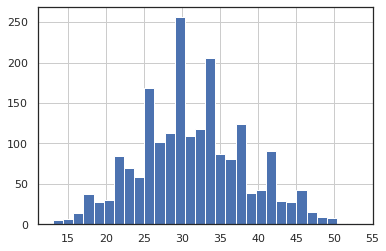

~> 데이터 균등성을 보완하기 위해 군집 데이터셋 추가

Text(0, 0.5, 'count')

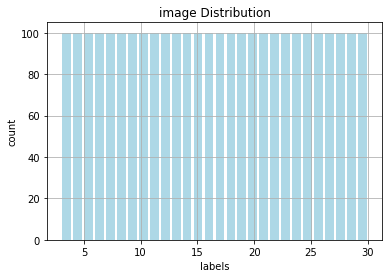

In [ ]:

plt.hist(labels, rwidth=.8, bins=28, color='lightblue')
plt.grid()
plt.title('image Distribution')
plt.xlabel('labels')
plt.ylabel('count')

In [ ]:
prediction = loaded_model.predict(imgs)

print(prediction.shape)
print(labels.shape)

(2800, 1)
(2800, 1)


예측값과 라벨의 분포를 산포도로 출력해본 결과 눈에 띄는 아웃라이어들을 제외하고는 선형관계를 확인할 수 있음


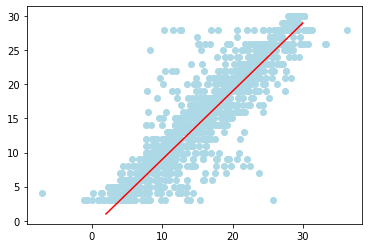

In [ ]:
plt.scatter(prediction[::2], labels[::2], c = 'lightblue')
plt.plot([2, 30], [1, 29], c = 'red')

In [ ]:
from PIL import Image, ImageFile
from IPython.display import display
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

In [ ]:
model = loaded_model
model_grad = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer('conv2d_7').output, model.output]
)

In [ ]:
def check_heatmap(img) : # img npy로 히트맵을 그리는 함수
  with tf.GradientTape() as tape:
    conv_outputs, predict = model_grad(img.reshape(-1, 120, 160, 3)) # 모델을 돌려서 output 2개 출력
    class_out = predict[:, np.argmax(predict[0])] # 타겟 Class 번호

  output = conv_outputs[0] # 타겟 Feature map
  grads = tape.gradient(class_out, conv_outputs)[0] # 편미분 결과
  weights = tf.reduce_mean(grads, axis=(0, 1)) # GAP 연산
  cam = np.ones(output.shape[0:2], dtype=np.float32) # CAM 초기화

  for index, w in enumerate(weights):
    cam += w * output[:, :, index] # Grad-CAM 연산

  cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
  cam = np.maximum(cam, 0) # ReLU 연산: 0 이하는 0, 0 이상은 그대로
  heatmap = (cam - cam.min()) / (cam.max() - cam.min()) # 0 ~ 1로 변환
  heatmap = np.uint8(255 * heatmap) # 0 ~ 255로 변환
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Color map 적용
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # BGR을 RGB로

  plt.title("")
  plt.imshow(heatmap)
  # output_image = cv2.addWeighted(img.astype('uint8'), 1, # 이미지 100%
  #                              heatmap, 0.5,           # heatmap 50%
  #                              0)
  # plt.imshow(output_image)
  # plt.axis('off')

In [ ]:
def check_heatmap_with_idx(idx) : # img 인덱스로 히트맵을 그리는 함수
  with tf.GradientTape() as tape:
    conv_outputs, predict = model_grad(imgs[idx].reshape(-1, 120, 160, 3)) # 모델을 돌려서 output 2개 출력
    class_out = predict[:, np.argmax(predict[0])] # 타겟 Class 번호

  output = conv_outputs[0] # 타겟 Feature map
  grads = tape.gradient(class_out, conv_outputs)[0] # 편미분 결과
  weights = tf.reduce_mean(grads, axis=(0, 1)) # GAP 연산
  cam = np.ones(output.shape[0:2], dtype=np.float32) # CAM 초기화

  for index, w in enumerate(weights):
    cam += w * output[:, :, index] # Grad-CAM 연산

  cam = cv2.resize(cam.numpy(), (imgs[idx].shape[1], imgs[idx].shape[0]))
  cam = np.maximum(cam, 0) # ReLU 연산: 0 이하는 0, 0 이상은 그대로
  heatmap = (cam - cam.min()) / (cam.max() - cam.min()) # 0 ~ 1로 변환
  heatmap = np.uint8(255 * heatmap) # 0 ~ 255로 변환
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Color map 적용
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # BGR을 RGB로

  plt.title(str(idx) + "th imgs heatmap")
  plt.imshow(heatmap)
  # output_image = cv2.addWeighted(img.astype('uint8'), 1, # 이미지 100%
  #                              heatmap, 0.5,           # heatmap 50%
  #                              0)
  # plt.imshow(output_image)
  # plt.axis('off')

### 정확도가 제일 높은 구간 그래프

> 각 구간별 정확도

In [ ]:
np_round_result = list(map(int, np.round(prediction).reshape(-1)))

In [ ]:
result = list(map(int, prediction))
print(result)
print(labels.reshape(-1))

[3, 4, 1, 7, 9, 2, 1, 2, 0, 5, 13, 3, 3, 1, 6, 3, 7, 3, 1, 4, 0, 9, 0, 0, 2, 0, 4, 4, 8, 11, 4, 1, 3, 3, 2, 4, 5, 3, 5, 17, 3, 13, 3, 3, 8, 1, 10, 6, 4, 1, 5, 2, 7, 10, 2, 3, 3, 6, 3, 3, 7, 2, 4, 3, -1, 5, 5, 0, 3, 6, 5, 20, 2, 6, 3, 0, 15, 9, 13, 4, 4, 2, 0, 5, 2, 10, 4, 2, 5, 3, 25, 4, 2, 5, 4, 2, 0, 2, 7, 12, 7, 5, 2, 4, 5, 7, 6, 7, 4, 3, 5, 0, 5, 4, 7, 7, 5, 6, 6, 19, 5, 5, 5, 5, 4, 3, 14, 0, 6, 5, 5, 10, 2, 2, 1, 6, 0, 5, 4, 6, 6, 4, 5, 5, 6, -5, 9, 15, 3, 3, 8, 9, 1, 3, 4, 4, 6, 3, 6, 7, 2, 7, 11, 2, 5, 10, 6, 5, 9, 6, 4, 4, 5, 7, 5, 8, 13, 4, -7, 12, 7, 2, 3, 8, 12, 8, 7, 9, 7, 8, 4, 6, 3, 5, 3, 6, 12, 6, 4, 8, 5, 15, 3, 18, 5, 5, 4, 4, 5, 4, 5, 2, 9, 9, 3, 14, 10, 5, 5, 12, 12, 13, 11, 6, 4, 2, 4, 12, 4, 2, 5, 7, 5, 9, 12, 3, 5, 6, 2, 6, 9, 8, 6, 6, 4, 6, 3, 5, 5, 5, 5, 3, 2, 6, 6, 4, 5, 7, 3, 5, 2, 5, 4, 6, 6, 4, 9, 4, 4, 7, 6, 8, 7, 18, 4, 3, 6, 1, 6, 4, 9, 11, 5, 22, 8, 5, 4, 7, 9, 9, 6, 11, 7, 7, 9, 6, 7, 6, 13, 6, 6, 9, 9, 6, 5, 4, 4, 3, 8, 8, 6, 0, 6, 4, 5, 6, 5, 6, 4, 4,

In [ ]:
df1 = pd.DataFrame()
df1.insert(0, 'labels', labels.reshape(-1))
df1.insert(1, 'prediction', result)
df1

,labels,prediction
0,3,3
1,3,4
2,3,1
3,3,7
4,3,9
...,...,...
2795,30,28
2796,30,29
2797,30,30
2798,30,29


In [ ]:
df2 = pd.DataFrame()
df2.insert(0, 'labels', labels.reshape(-1))
df2.insert(1, 'prediction_round', np_round_result)
df2

,labels,prediction_round
0,3,3
1,3,5
2,3,2
3,3,8
4,3,10
...,...,...
2795,30,29
2796,30,29
2797,30,30
2798,30,29


In [ ]:
dist = [3, 7, 11, 15, 19, 23, 27]

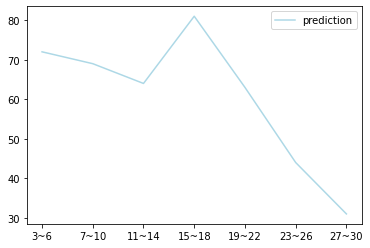

In [ ]:
dist_sum1 = []

for i in dist :
  tot = df1_sum.loc[i : i + 3].sum()
  dist_sum1.append(tot)

pd.DataFrame(dist_sum1, index=['3~6', '7~10', '11~14', '15~18', '19~22', '23~26', '27~30']).plot(c = 'lightblue')

우리가 설계한 모델의 피처맵 확인을 위한 히트맵
 사람의 얼굴 부분을 위주로 특징을 잡아낼 것이라 기대했지만

> 실제로는 길쭉한 사람의 형상을 위주로 인식했음을 확인할 수 있었음
> 따라서 사람의 얼굴이 크게 나온 사진보다는 형체가 모두 보이는 화각을 가진 사진에서의 인식률이 더 높음
>> 본 프로젝트의 목표인 cctv를 통한 군집 제어 목표에 적합한 모델로 보임



In [ ]:
## 마지막 conv 레이어에서 뽑아낸 히트맵
#17, (31, 32 ~> 정장 와이셔츠(흰색)을 위주로 피처 잡음), 34, 37, 40(어두워서 형체가 잘 안보이는 사람도 잡아냄)
# 48(사람얼굴 잘 찾아냄), 51, 56, 59, 68(사람의 형상 위주로 잘 잡음), 75, 85, 138
#154, 156, 164
#1003, 1010

label :  [3] , prediction :  3


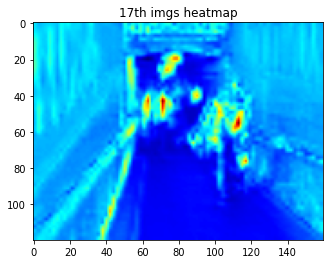

In [ ]:
idx = 17
check_heatmap_with_idx(idx)
print("label : ", labels[idx], ", prediction : ", int(prediction[idx]))

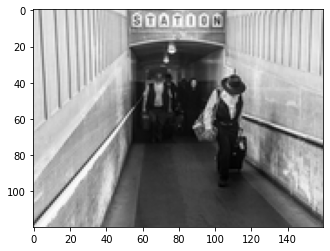

In [ ]:
plt.imshow(imgs[idx])

label :  [3] , prediction :  2


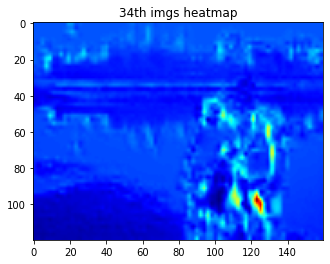

In [ ]:
idx = 34
check_heatmap_with_idx(idx)
print("label : ", labels[idx], ", prediction : ", int(prediction[idx]))

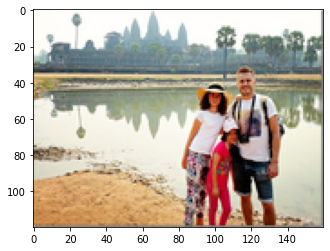

In [ ]:
plt.imshow(imgs[idx])

label :  [3] , prediction :  3


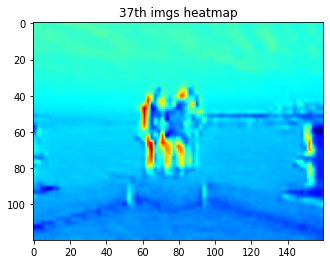

In [ ]:
idx = 37
check_heatmap_with_idx(idx)
print("label : ", labels[idx], ", prediction : ", int(prediction[idx]))

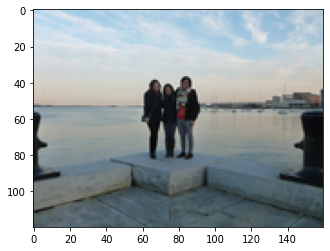

In [ ]:
plt.imshow(imgs[idx])

label :  [4] , prediction :  6


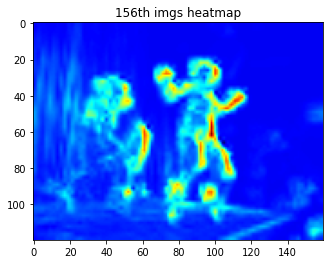

In [ ]:
idx = 156
check_heatmap_with_idx(idx)
print("label : ", labels[idx], ", prediction : ", int(prediction[idx]))

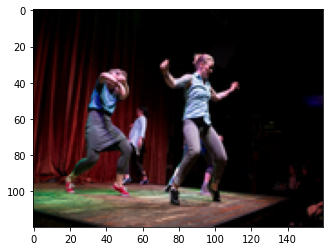

In [ ]:
plt.imshow(imgs[idx])

label :  [3] , prediction :  4


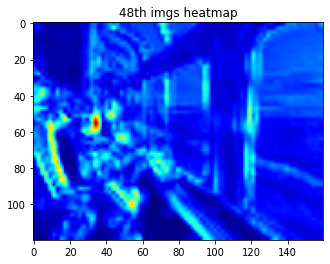

In [ ]:
idx = 48
check_heatmap_with_idx(idx)
print("label : ", labels[idx], ", prediction : ", int(prediction[idx]))

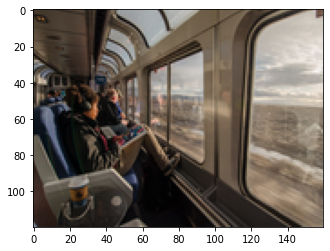

In [ ]:
plt.imshow(imgs[idx])

label :  [13] , prediction :  12


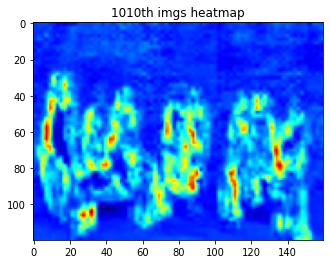

In [ ]:
idx = 1010
check_heatmap_with_idx(idx)
print("label : ", labels[idx], ", prediction : ", int(prediction[idx]))

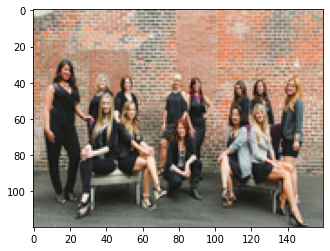

In [ ]:
plt.imshow(imgs[idx])

label :  [13] , prediction :  16


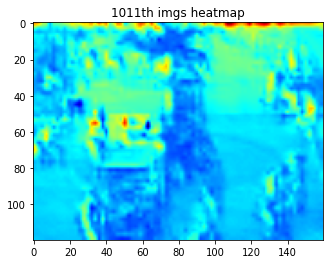

In [ ]:
idx = 1011
check_heatmap_with_idx(idx)
print("label : ", labels[idx], ", prediction : ", int(prediction[idx]))

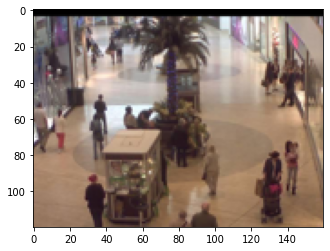

In [ ]:
plt.imshow(imgs[idx])

label :  [4] , prediction :  4


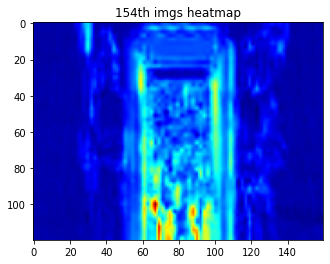

In [ ]:
idx = 154
check_heatmap_with_idx(idx)
print("label : ", labels[idx], ", prediction : ", int(prediction[idx]))

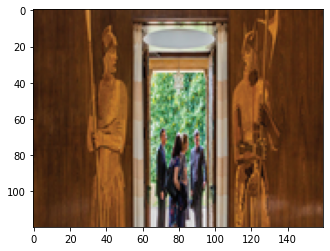

In [ ]:
plt.imshow(imgs[idx])